In [1]:
!pip install finance-datareader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime, timedelta
import random

num_images = 5000
day_num = 32

In [4]:
def convert_image(data, num_images, day_num, change_std, save = False, test = False):
    if test:
        change_std = 0

    def alpha_blend(color1, color2, alpha):
        return [
            int((color1[0] * alpha + color2[0] * (1 - alpha))),
            int((color1[1] * alpha + color2[1] * (1 - alpha))),
            int((color1[2] * alpha + color2[2] * (1 - alpha))),
            255,
        ]

    # 데이터수가 너무 적으면 패스
    if len(data) <= 100:
        return []


    # 해당 종목의 주가 데이터 - 100이 요구되는 이미지 수보다 적으면(상장직후는 변동이 심할 수있으니 제외)
    if num_images - 52 > len(data):
        num_images = len(data) - 52

    #return_datas는 이미지, 라벨링(상승이면1 하락이면0), 변동률, 날짜를 담고있음
    return_datas = []
    prediction_day_num = 5


    image_idx = 1
    while(image_idx <= num_images):
        prediction_day = data[-image_idx - prediction_day_num : -image_idx]
        predict_mean = prediction_day['Close'].mean()
        now = data.iloc[-image_idx - prediction_day_num - 1]
        change = (predict_mean - now['Close']) / now['Close']


        # change가 너무 높으면 이상치라고 판단하여 패스
        if not test and (abs(change) < change_std or change_std * 4 < abs(change)): # 향후 prediction_day_num일의 변동률이 기준 이하면
            image_idx += 1
            continue

        stock_data = data[-image_idx - day_num - prediction_day_num : -image_idx - prediction_day_num]

        # 이미지 크기 설정
        width, height = 96, 96

        # High, Low, Close, Volume 데이터 정규화
        high_prices = stock_data['High'].values
        low_prices = stock_data['Low'].values
        close_prices = stock_data['Close'].values
        volume_data = stock_data['Volume'].values

        high_prices_norm = (high_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        low_prices_norm = (low_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        close_prices_norm = (close_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        volume_data_norm = height * (volume_data) / (2 * (np.max(volume_data)))

        # 이동평균선 추가를 위한 stock_data 생성
        stock_data_ma20 = data[-image_idx - day_num - 20 - prediction_day_num: -image_idx - prediction_day_num]
        stock_data_ma20 = stock_data_ma20.copy()
        stock_data_ma20['MA20'] = stock_data_ma20['Close'].rolling(window=20).mean()
        stock_data_ma20.dropna(inplace=True)

        # 이동평균선 값을 정규화
        stock_data_ma20['MA20_norm'] = (
                (stock_data_ma20['MA20'] - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
            )

        # 96x96 이미지 생성
        img = np.zeros((height, width, 4), dtype=np.uint8)  # 4 channels for RGBA

        fail_generate = False
        for day in range(32):
            high_price = int(high_prices_norm[day] * (height - 1))
            low_price = int(low_prices_norm[day] * (height - 1))
            close_price = int(close_prices_norm[day] * (height - 1))
            open_price = int(
                (
                    (stock_data['Open'].values[day] - np.min(low_prices))
                    / (np.max(high_prices) - np.min(low_prices))
                )
                * (height - 1)
            )
            volume = int(volume_data_norm[day])
            if(volume == 0):
                fail_generate = True
                break

            x_start = day * 3

            # 시가, 종가, 고가, 저가 막대그래프
            # 막대 왼쪽, 오른쪽 그리기 (시가, 종가 범위)
            for x in range(x_start, x_start + 3):
                if close_prices[day] > stock_data['Open'].values[day]:
                    color = [255, 0, 0, 255]  # 상승: 빨강
                    tail_color = [200, 0, 0, 255]  # 상승 시 꼬리: 어두운 빨강
                elif close_prices[day] < stock_data['Open'].values[day]:
                    color = [0, 0, 255, 255]  # 하락: 파랑
                    tail_color = [0, 0, 200, 255]  # 하락 시 꼬리: 어두운 파랑
                else: # 시가와 종가가 같을경우 어제보다 같거나 올랐으면 빨강, 아니면 파랑
                    if 0 <= stock_data['Change'].values[day]:
                        color = [255, 0, 0, 255]  # 상승: 빨강
                        tail_color = [200, 0, 0, 255]  # 상승 시 꼬리: 어두운 빨강
                    else:
                        color = [0, 0, 255, 255]  # 하락: 파랑
                        tail_color = [0, 0, 200, 255]  # 하락 시 꼬리: 어두운 파랑

                for y in range(min(open_price, close_price), max(open_price, close_price) + 1):
                    img[height - 1 - y, x] = color

            # 꼬리 그리기 (High, Low 범위)
            for x in range(x_start + 1, x_start + 2):
                for y in range(low_price, high_price + 1):
                    if img[height - 1 - y, x][0] != 255 and img[height - 1 - y, x][2] != 255:
                        img[height - 1 - y, x] = tail_color

            # 거래량 그리기
            for x in range(x_start, x_start + 3):
                overlapped = height - volume
                if overlapped >= 0 and overlapped < height:
                    img[overlapped:, x] = [
                        alpha_blend(img[y, x], [128, 128, 128, 255], 0.45)
                        for y in range(overlapped, height)
                    ]

            # 20일 이동평균선 그리기
            ma20_norm = stock_data_ma20.iloc[day]['MA20_norm']

            for x in range(x_start, x_start + 3):
                if not np.isnan(ma20_norm):
                    ma20_y = int(ma20_norm * (height - 1))
                    if 0 <= ma20_y < height:
                        for y in range(ma20_y - 1, ma20_y + 2):  # 이동평균선 주변에 블렌딩 처리
                            if 0 <= y < height:
                                new_color = alpha_blend([255, 255, 0, 255], img[height - 1 - y, x], 0.6)  # 노란색으로 변경
                                img[height - 1 - y, x] = new_color

        #이미지가 day_num(그려지기 원하는 거래일 수)미만으로 그려졌으면
        if fail_generate:
            image_idx += prediction_day_num
            continue

        if save :
            # 이미지 저장
            img = Image.fromarray(img, 'RGBA')
            img.save(f'samsung_stock_data_image_{image_idx}.png')

        if change_std <= change:
            return_datas.append((img, 1))
        elif change <= -change_std :
            return_datas.append((img, 0))

            # 테스트는 촘촘하게 모든 데이터로
        if test:
            image_idx += 1
        else:
            # 비슷한 이미지를 피하기 위해 기준 예측일만큼 건너뜀
            image_idx += 1


    return return_datas

In [5]:
def preprocess_data(data):
    # 0이나 NaN을 포함하는 행 제거
    data = data[data['Volume'] != 0]
    data = data.dropna(how='any')

    return data

In [6]:
import random

def get_same_labelnum(result, num):
    local_random = random.Random(42)

    # 라벨별로 이미지 데이터 분리
    label0_images = [image_data for image_data, label in result if label == 0]
    label1_images = [image_data for image_data, label in result if label == 1]

    # 각 라벨에서 랜덤하게 5,000개씩 뽑기
    random_label0_images = local_random.sample(label0_images, num)
    random_label1_images = local_random.sample(label1_images, num)

    # 뽑은 이미지 데이터와 라벨을 다시 묶기
    new_label0_result = [(image_data, 0) for image_data in random_label0_images]
    new_label1_result = [(image_data, 1) for image_data in random_label1_images]

    # 두 결과를 번갈아가면서 합치기
    result = [t for pair in zip(new_label0_result, new_label1_result) for t in pair]
    return result

In [7]:
# 엑셀 파일 읽기
df = pd.read_csv('drive/MyDrive/Colab Notebooks/kosdaq.csv', usecols=[0, 1], dtype={1: str})
df = df[~df.iloc[:, 0].str.contains("스팩")]
df = df.iloc[:, [1, 0]]
# df = df.sample(n=400, random_state=42)
# 첫 번째 열과 두 번째 열을 Nx2 리스트로 변환
stock_codes = df.values.tolist()

# 결과 출력
print(stock_codes)

[['448710', '코츠테크놀로지'], ['445680', '큐리옥스바이오시스템즈'], ['440110', '파두'], ['373170', '엠아이큐브솔루션'], ['429270', '시지트로닉스'], ['172670', '에이엘티'], ['388870', '파로스아이바이오'], ['438700', '버넥트'], ['406820', '뷰티스킨'], ['432430', '와이랩'], ['321370', '센서뷰'], ['378340', '필에너지'], ['274400', '이노시뮬레이션'], ['354320', '알멕'], ['440320', '오픈놀'], ['232830', '시큐센'], ['303360', '프로테옴텍'], ['348080', '큐라티스'], ['439090', '마녀공장'], ['405920', '나라셀라'], ['285800', '진영'], ['420770', '기가비스'], ['271830', '팸텍'], ['434480', '모니터랩'], ['340810', '씨유박스'], ['417790', '트루엔'], ['304360', '에스바이오메딕스'], ['298830', '슈어소프트테크'], ['393210', '토마토시스템'], ['424980', '마이크로투나노'], ['318160', '셀바이오휴먼텍'], ['358570', '지아이이노베이션'], ['309960', 'LB인베스트먼트'], ['356680', '엑스게이트'], ['282720', '금양그린파워'], ['418420', '라온텍'], ['389020', '자람테크놀로지'], ['417010', '나노팀'], ['199730', '바이오인프라'], ['344860', '이노진'], ['127980', '화인써키트'], ['418550', '제이오'], ['411080', '샌즈랩'], ['407400', '꿈비'], ['408900', '스튜디오미르'], ['419050', '삼기이브이'], ['417860', '오브젠'], ['254490', '미래반도체'], [

In [8]:
# train_result = []
for i, ticker in enumerate(stock_codes):
    code, name = ticker[0], ticker[1]
    print(f"{i+1}번째 종목 {name} 추출중...   ")

    try:
        cnt = 0
        data = preprocess_data(fdr.DataReader(code, '2013-09-01', '2020-02-15'))  # 각 종목의 데이터 가져오기
        images = convert_image(data, 5000, day_num, 0.15)
        train_result += images
        cnt += len(images)
        data = preprocess_data(fdr.DataReader(code, '2020-05-01', '2022-12-31'))  # 각 종목의 데이터 가져오기
        images = convert_image(data, 5000, day_num, 0.15)
        train_result += images
        cnt += len(images)
        print(f"{cnt}개 추출완료. 누적{len(train_result)}개")
    except IndexError:
        print(f"{name}에서 IndexError가 발생했습니다. 다음 종목으로 이동합니다.")
        continue

1번째 종목 코츠테크놀로지 추출중...   
0개 추출완료. 누적0개
2번째 종목 큐리옥스바이오시스템즈 추출중...   
0개 추출완료. 누적0개
3번째 종목 파두 추출중...   
0개 추출완료. 누적0개
4번째 종목 엠아이큐브솔루션 추출중...   
0개 추출완료. 누적0개
5번째 종목 시지트로닉스 추출중...   
0개 추출완료. 누적0개
6번째 종목 에이엘티 추출중...   
0개 추출완료. 누적0개
7번째 종목 파로스아이바이오 추출중...   
0개 추출완료. 누적0개
8번째 종목 버넥트 추출중...   
0개 추출완료. 누적0개
9번째 종목 뷰티스킨 추출중...   
0개 추출완료. 누적0개
10번째 종목 와이랩 추출중...   
0개 추출완료. 누적0개
11번째 종목 센서뷰 추출중...   
0개 추출완료. 누적0개
12번째 종목 필에너지 추출중...   
0개 추출완료. 누적0개
13번째 종목 이노시뮬레이션 추출중...   
0개 추출완료. 누적0개
14번째 종목 알멕 추출중...   
0개 추출완료. 누적0개
15번째 종목 오픈놀 추출중...   
0개 추출완료. 누적0개
16번째 종목 시큐센 추출중...   
7개 추출완료. 누적7개
17번째 종목 프로테옴텍 추출중...   
0개 추출완료. 누적7개
18번째 종목 큐라티스 추출중...   
0개 추출완료. 누적7개
19번째 종목 마녀공장 추출중...   
0개 추출완료. 누적7개
20번째 종목 나라셀라 추출중...   
0개 추출완료. 누적7개
21번째 종목 진영 추출중...   
0개 추출완료. 누적7개
22번째 종목 기가비스 추출중...   
0개 추출완료. 누적7개
23번째 종목 팸텍 추출중...   
0개 추출완료. 누적7개
24번째 종목 모니터랩 추출중...   
0개 추출완료. 누적7개
25번째 종목 씨유박스 추출중...   
0개 추출완료. 누적7개
26번째 종목 트루엔 추출중...   
0개 추출완료. 누적7개
27번째 종목 에스바이오메딕스 추출중...   
0개 추출완료. 누

In [9]:
print(len(train_result))
print(sum([low[1] for low in train_result]))

22458
17720


In [10]:
train_result = get_same_labelnum(train_result, 4500)
train_images, train_labels = zip(*train_result)
print(sum(train_labels))
np.save('train_images.npy', train_images)
np.save('train_labels.npy', train_labels)

4500


In [ ]:
test_result = []
for i, ticker in enumerate(stock_codes):
    code, name = ticker[0], ticker[1]
    print(f"{i+1}번째 종목 {name} 추출중...   ")
    try:
        data = preprocess_data(fdr.DataReader(code, "2022-12-01"))  # 각 종목의 데이터 가져오기
        images = convert_image(data, 300, day_num, 0.15)
        test_result += images
        print(f"{len(images)}개 추출완료. 누적{len(test_result)}개")
    except IndexError:
        print(f"{name}에서 IndexError가 발생했습니다. 다음 종목으로 이동합니다.")
        continue

1번째 종목 코츠테크놀로지 추출중...   
0개 추출완료. 누적0개
2번째 종목 큐리옥스바이오시스템즈 추출중...   
0개 추출완료. 누적0개
3번째 종목 파두 추출중...   
0개 추출완료. 누적0개
4번째 종목 엠아이큐브솔루션 추출중...   
0개 추출완료. 누적0개
5번째 종목 시지트로닉스 추출중...   
0개 추출완료. 누적0개
6번째 종목 에이엘티 추출중...   
0개 추출완료. 누적0개
7번째 종목 파로스아이바이오 추출중...   
0개 추출완료. 누적0개
8번째 종목 버넥트 추출중...   
0개 추출완료. 누적0개
9번째 종목 뷰티스킨 추출중...   
0개 추출완료. 누적0개
10번째 종목 와이랩 추출중...   
0개 추출완료. 누적0개
11번째 종목 센서뷰 추출중...   
0개 추출완료. 누적0개
12번째 종목 필에너지 추출중...   
0개 추출완료. 누적0개
13번째 종목 이노시뮬레이션 추출중...   
0개 추출완료. 누적0개
14번째 종목 알멕 추출중...   
0개 추출완료. 누적0개
15번째 종목 오픈놀 추출중...   
0개 추출완료. 누적0개
16번째 종목 시큐센 추출중...   
2개 추출완료. 누적2개
17번째 종목 프로테옴텍 추출중...   
1개 추출완료. 누적3개
18번째 종목 큐라티스 추출중...   
0개 추출완료. 누적3개
19번째 종목 마녀공장 추출중...   
0개 추출완료. 누적3개
20번째 종목 나라셀라 추출중...   
0개 추출완료. 누적3개
21번째 종목 진영 추출중...   
0개 추출완료. 누적3개
22번째 종목 기가비스 추출중...   
0개 추출완료. 누적3개
23번째 종목 팸텍 추출중...   
0개 추출완료. 누적3개
24번째 종목 모니터랩 추출중...   
0개 추출완료. 누적3개
25번째 종목 씨유박스 추출중...   
0개 추출완료. 누적3개
26번째 종목 트루엔 추출중...   
0개 추출완료. 누적3개
27번째 종목 에스바이오메딕스 추출중...   
0개 추출완료. 누

In [ ]:
print(len(test_result))
print(sum([low[1] for low in test_result]))

1765
1479


In [ ]:
test_result = get_same_labelnum(test_result, 1500)
test_images, test_labels = zip(*test_result)
print(sum(test_labels))
np.save('test_images.npy', test_images)
np.save('test_labels.npy', test_labels)

1500


In [11]:
train_images = np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
# test_images = np.load('test_images.npy')
# test_labels = np.load('test_labels.npy')

train_images = train_images[:, :, :, :3]
# test_images = test_images[:, :, :, :3]

np.save('train_images.npy', train_images)
np.save('train_labels.npy', train_labels)
# np.save('test_images.npy', test_images)
# np.save('test_labels.npy', test_labels)

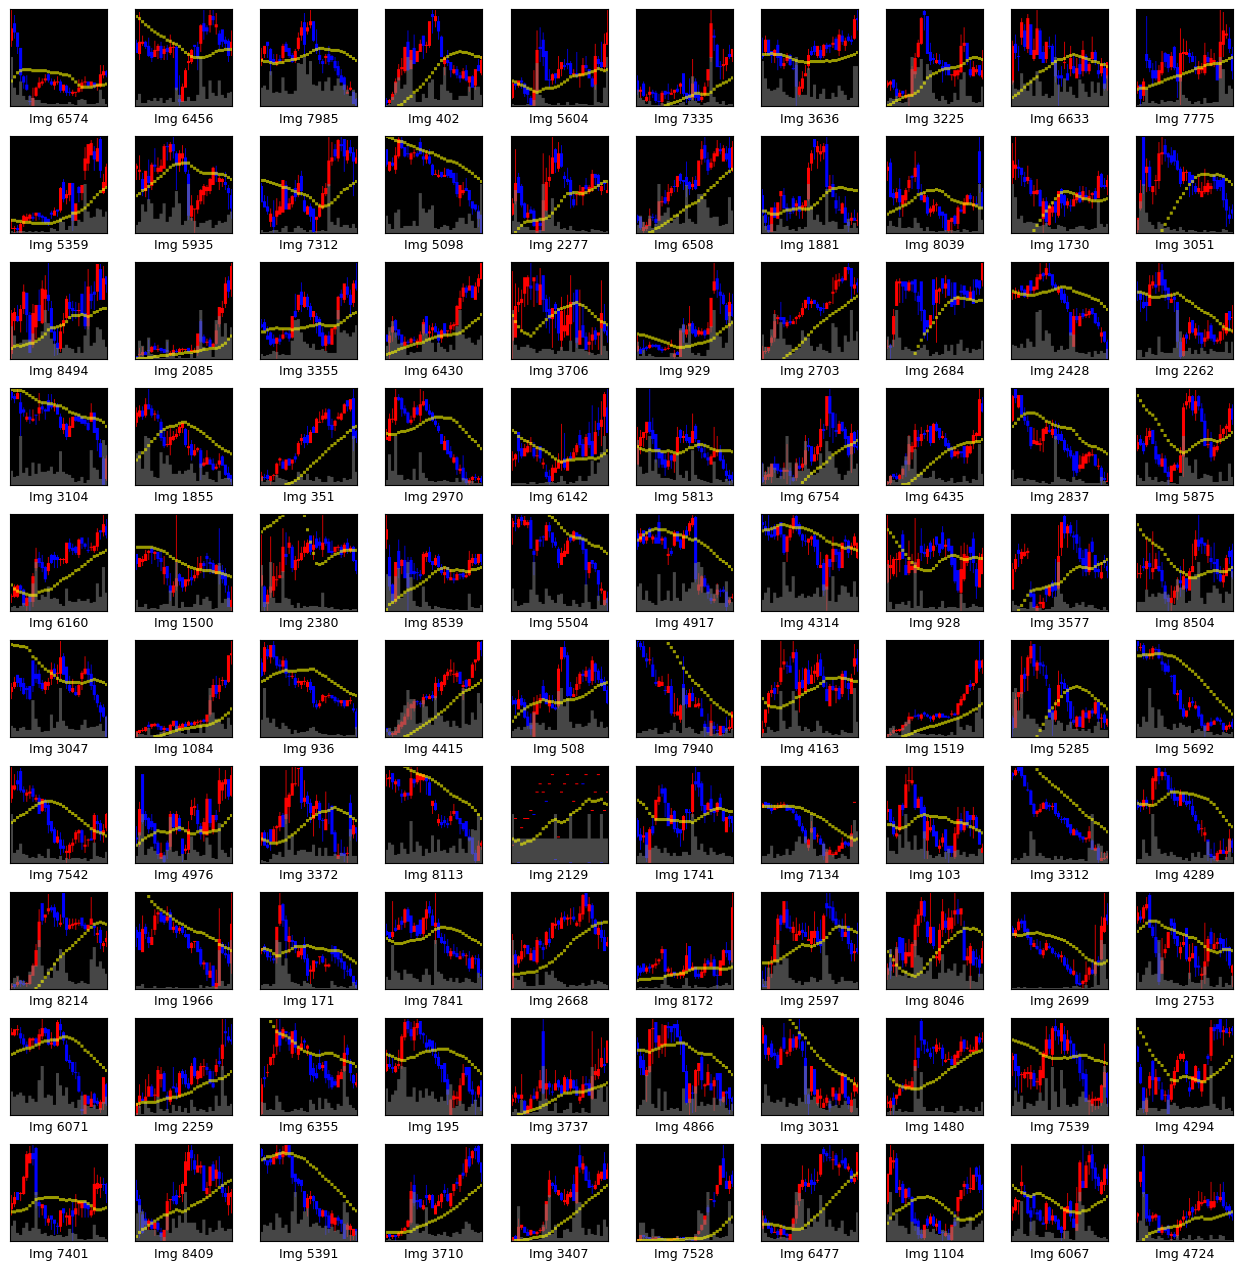

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 이미지 개수와 그리드 크기 설정
num_images = len(train_images)
num_to_display = 100
grid_size = int(np.sqrt(num_to_display))

# 랜덤으로 이미지 인덱스 선택
random_indices = np.random.choice(num_images, num_to_display, replace=False)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(16, 16))
for i in range(grid_size):
    for j in range(grid_size):
        img_idx = random_indices[i * grid_size + j]
        img = Image.fromarray(train_images[img_idx])
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_xlabel(f'Img {img_idx + 1}', fontsize=9)

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

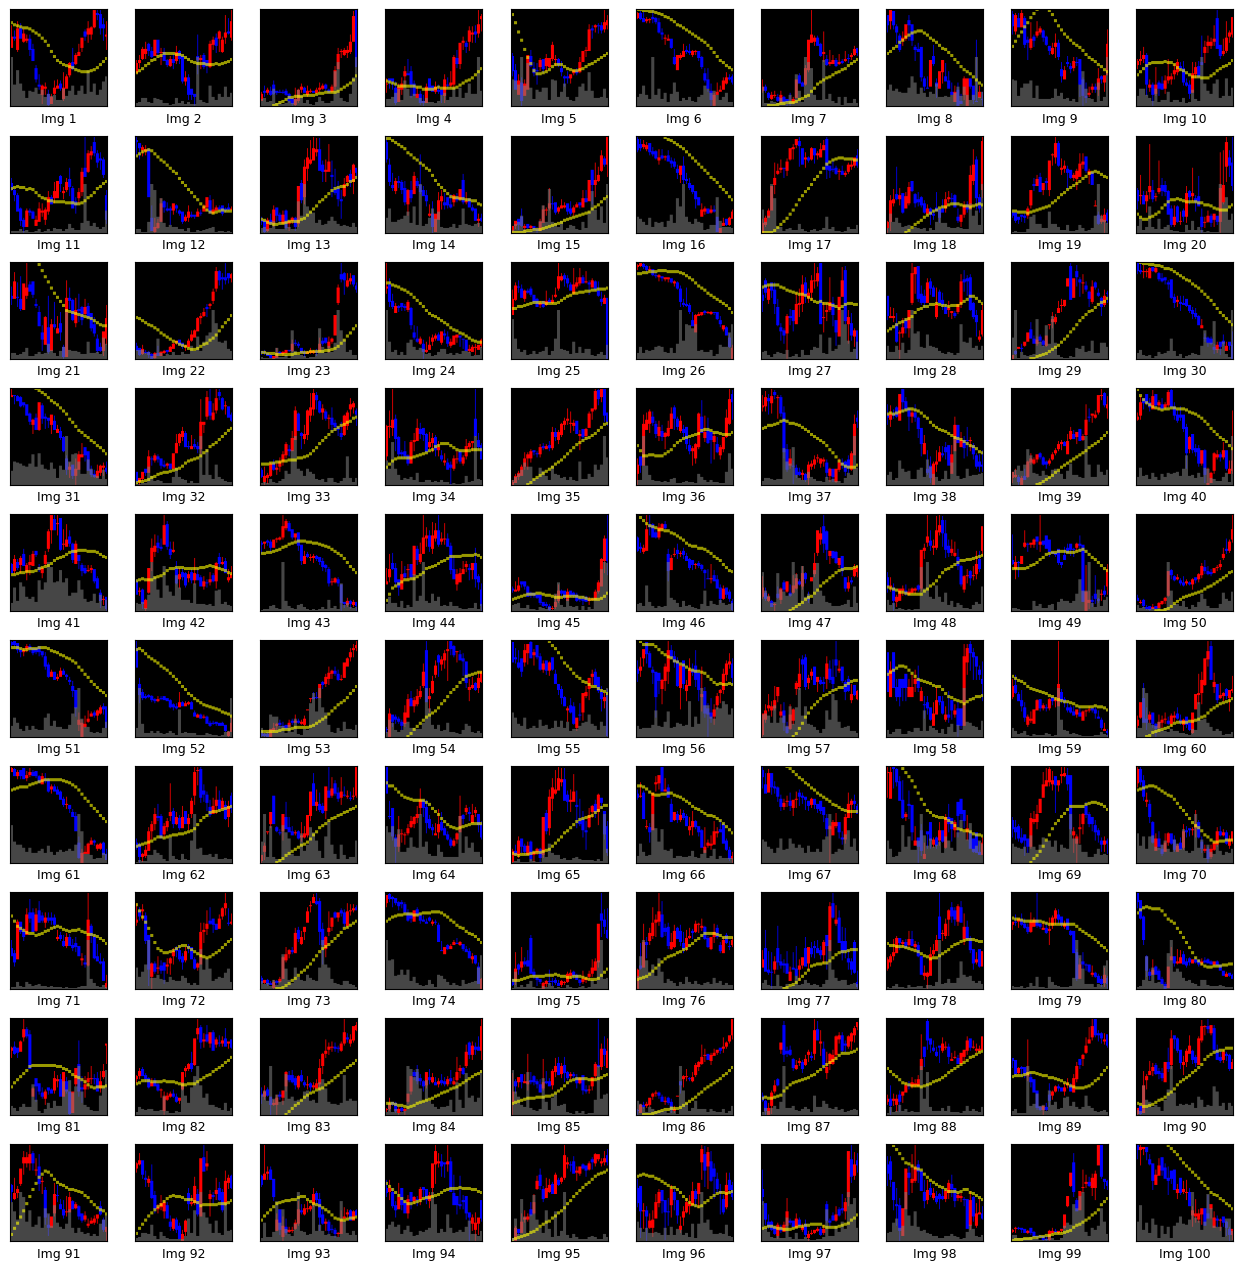

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(16, 16))
for i in range(10):
    for j in range(10):
        img_idx = i * 10 + j
        img = Image.fromarray(train_images[img_idx])
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_xlabel(f'Img {img_idx + 1}', fontsize=9)

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()
